In [1]:
import histomicstk as htk
import numpy as np
import scipy as sp
import skimage.io
import skimage.measure
import skimage.color
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 15, 15
plt.rcParams['image.cmap'] = 'gray'
titlesize = 24



inputImageFile = ('/disk1/rpn/data/BM_GRAZ/source/BM_GRAZ_HE_0008_01.png')  # Easy1.png
imInput = skimage.io.imread(inputImageFile)[:, :, :3]
refImageFile = ('/disk1/rpn/data/BM_GRAZ/source/BM_GRAZ_HE_0007_01.png')  # L1.png
imReference = skimage.io.imread(refImageFile)[:, :, :3]
# get mean and stddev of reference image in lab space
meanRef, stdRef = htk.preprocessing.color_conversion.lab_mean_std(imReference)
# perform reinhard color normalization
imNmzd = htk.preprocessing.color_normalization.reinhard(imInput, meanRef, stdRef)

w_est = htk.preprocessing.color_deconvolution.rgb_separate_stains_macenko_pca(imNmzd,I_0=255 )
I_0=255
stain_color_map = htk.preprocessing.color_deconvolution.stain_color_map
# specify stains of input image
stains = ['hematoxylin',  # nuclei stain
          'eosin',        # cytoplasm stain
          'null']    
# Perform color deconvolution
deconv_result = htk.preprocessing.color_deconvolution.color_deconvolution(imInput, w_est, I_0)
#print('Estimated stain colors (rows):', w_est.T[:2])
# Display results
    #print channel
   # plt.imshow(deconv_result.Stains[:, :, channel])
   # _ = plt.title(stains[i], fontsize=titlesize)

    
    
imNucleiStain = deconv_result.Stains[:, :, 1]
#plt.figure()
#plt.imshow(imNucleiStain)
#imNucleiStain =imDeconvolved[:, :, 0]
foreground_threshold =120

imFgndMask = sp.ndimage.morphology.binary_fill_holes(
    imNucleiStain < foreground_threshold)



min_radius = 5
max_radius = 30
imLog = htk.filters.shape.clog(imNucleiStain, imFgndMask,
                               sigma_min=min_radius * np.sqrt(2),
                               sigma_max=max_radius * np.sqrt(2))
# detect and segment nuclei using local maximum clustering
local_max_search_radius = 10
imNucleiSegMask1, Seeds, Max = htk.segmentation.nuclear.max_clustering(
    imLog[0], imFgndMask, local_max_search_radius)
# filter out small objects
min_nucleus_area = 200
imNucleiSegMask = htk.segmentation.label.area_open(
    imNucleiSegMask1, min_nucleus_area).astype(np.int)
# compute nuclei properties
objProps = skimage.measure.regionprops(imNucleiSegMask)
print 'Number of nuclei = ', len(objProps)
    


Number of nuclei =  495


In [2]:
imNucleicompact = htk.segmentation.label.compact(imNucleiSegMask, compaction=3)

k= (imNucleicompact==-1)
imNucleicompact1=np.copy(k)
plt.rcParams['figure.figsize'] = 15,15    
for ii in range(0,1200):
    for jj in range(0,1200):
        if imNucleicompact[ii,jj]>0:
            imNucleicompact1[ii,jj]=1
            
imNucleicompact2 = skimage.measure.label(imNucleicompact1,connectivity = 1)

In [3]:
imNucleicompact2.max()

572

In [4]:
imNucleicompact2 = skimage.measure.label(imNucleicompact1,connectivity = 1)
imInput2 = np.copy(imInput)
plt.rcParams['figure.figsize'] = 1, 1
listt = []

import cv2
for i in range(1,imNucleicompact2.max()):
    
    k =  (imNucleicompact2==i)
    location = np.where(k == 1)
    x_min, y_min = min(location[0]),min(location[1])
    x_max, y_max = max(location[0]),max(location[1])
    space = (x_max-x_min)*(y_max-y_min)

    if space<450 and space>100:
        print i
        print space
        segmentate = k[x_min:x_max,y_min:y_max]
        segmentate = np.tile(np.expand_dims(segmentate,axis=2),(1,1,3))
        img = imInput[x_min:x_max,y_min:y_max,:]
        img = img*segmentate
        listt.append(img)
        #plt.imshow(img)
        #plt.show()

    if space>449:
        print i
        print space
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(7, 7)) 
        k.dtype=np.uint8
        eroded=cv2.erode(k,kernel);
        dilated = cv2.dilate(eroded,kernel)
        new_seg = skimage.measure.label(dilated,connectivity = 1)
        for j in range (1,new_seg.max()+1):
            print 'j=',j
            kk =  (new_seg==j)
            location1 = np.where(kk == 1)
            x_min1, y_min1 = min(location1[0]),min(location1[1])
            x_max1, y_max1 = max(location1[0]),max(location1[1])
            space1 = (x_max1-x_min1)*(y_max1-y_min1)
            if space1< 800:
                segmentate = kk[x_min1:x_max1,y_min1:y_max1]
                segmentate = np.tile(np.expand_dims(segmentate,axis=2),(1,1,3))
                img1 = imInput[x_min1:x_max1,y_min1:y_max1,:]
                img1 = img1*segmentate
                listt.append(img1)
                #plt.imshow(img1)
                #plt.show()

1
232
2
864
j= 1
3
435
4
782
j= 1
j= 2
6
323
7
252
8
520
j= 1
11
336
12
342
13
154
14
837
j= 1
15
589
j= 1
j= 2
17
361
18
450
j= 1
20
374
21
506
j= 1
22
380
23
868
j= 1
24
266
27
224
29
324
30
1806
j= 1
31
340
32
320
33
165
34
306
35
441
39
182
40
320
41
437
42
399
43
340
44
361
45
494
j= 1
47
192
49
380
50
378
51
506
j= 1
53
459
j= 1
j= 2
54
361
55
342
56
289
58
368
59
320
60
224
61
323
62
450
j= 1
63
336
64
364
67
340
68
483
j= 1
69
234
70
1760
j= 1
71
567
j= 1
72
486
j= 1
73
320
74
360
75
550
j= 1
77
361
78
306
79
361
80
255
81
306
82
168
83
143
84
450
j= 1
85
1476
j= 1
j= 2
j= 3
86
289
87
324
88
483
j= 1
89
400
90
462
j= 1
91
897
j= 1
92
986
j= 1
93
399
94
320
95
483
j= 1
96
441
97
323
98
192
99
624
j= 1
100
1312
j= 1
101
414
102
442
103
480
j= 1
104
418
106
288
107
594
j= 1
108
357
110
288
111
210
112
468
j= 1
114
342
115
600
j= 1
116
340
117
380
118
476
j= 1
j= 2
119
272
120
495
j= 1
121
340
122
340
123
342
124
105
125
768
j= 1
126
306
127
550
j= 1
130
550
j= 1
131
342
132
456
j=

In [5]:
print len(listt)

472


In [10]:
image_dict = {}
n=0
for img in listt:
    color_mean = img.mean(axis=2)
    for i in range(0, color_mean.shape[0]):
        for j in range(0, color_mean.shape[1]):
            if color_mean[i,j] == 0.0:
                img[i,j,:] = 255

    height, width = img.shape[0], img.shape[1]
    if max(height,width)>32:
        scale = 32/float(max(height,width))
        height, width = int(height*scale), int(width*scale)
        img = sp.misc.imresize(img, (height, width))

    npad = ((16-height/2,32-height-(16-height/2)),(16-width/2,32-width-(16-width/2)),(0,0))
    segmentate_image = np.pad(img, pad_width=npad,constant_values=0,mode='constant')
    image_dict[n] = segmentate_image
    n+=1
    
print ('Number of nuclei = ', len(image_dict))
image = np.array(image_dict.values())
#np.save('/disk1/0721_fullfill/{0}.npy'.format(inputImageFile[-9:-4]),image)
print ('done')


('Number of nuclei = ', 472)
done


In [9]:
n

472

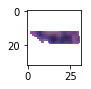

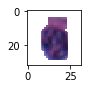

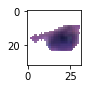

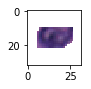

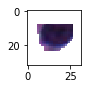

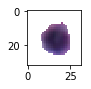

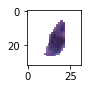

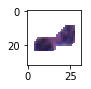

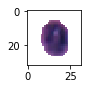

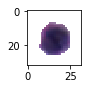

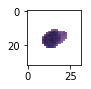

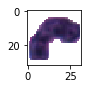

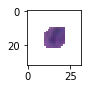

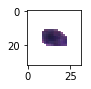

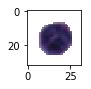

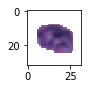

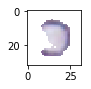

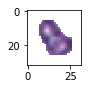

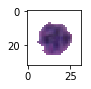

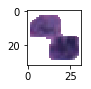

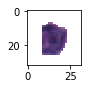

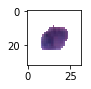

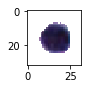

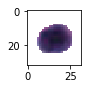

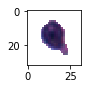

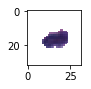

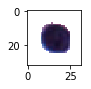

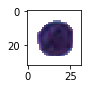

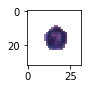

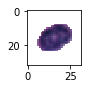

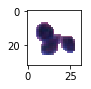

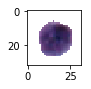

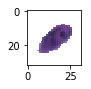

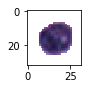

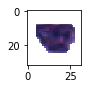

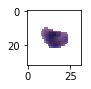

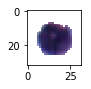

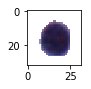

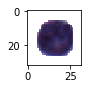

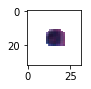

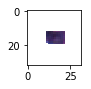

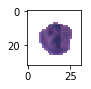

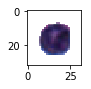

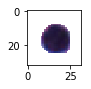

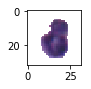

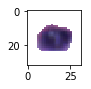

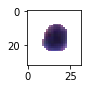

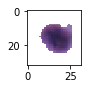

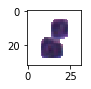

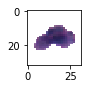

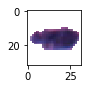

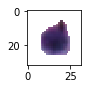

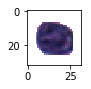

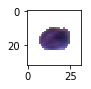

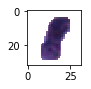

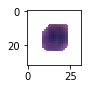

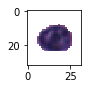

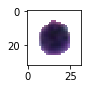

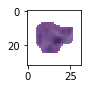

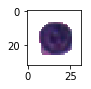

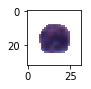

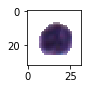

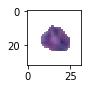

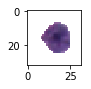

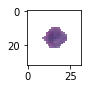

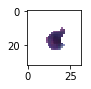

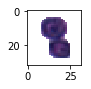

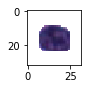

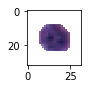

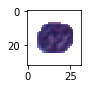

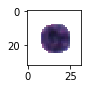

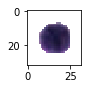

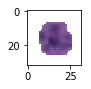

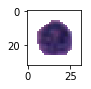

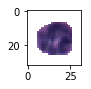

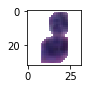

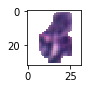

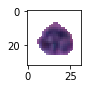

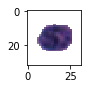

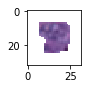

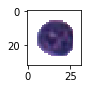

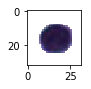

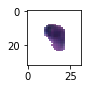

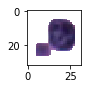

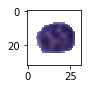

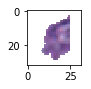

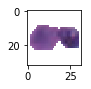

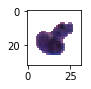

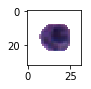

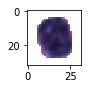

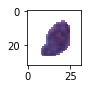

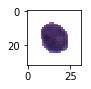

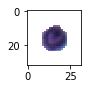

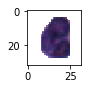

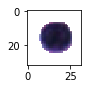

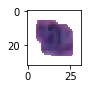

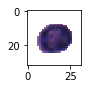

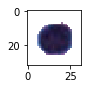

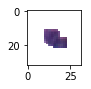

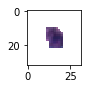

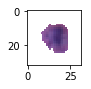

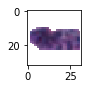

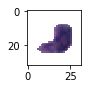

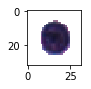

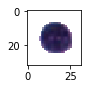

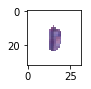

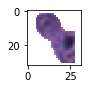

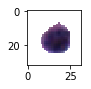

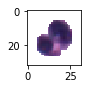

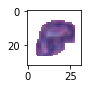

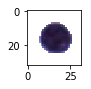

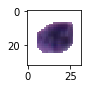

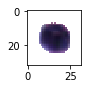

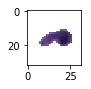

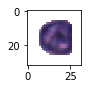

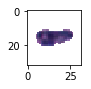

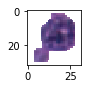

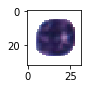

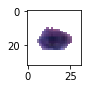

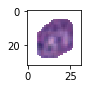

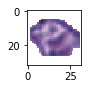

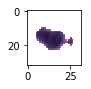

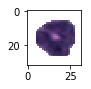

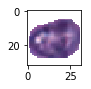

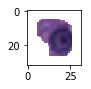

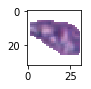

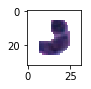

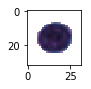

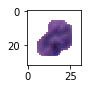

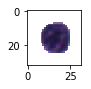

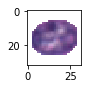

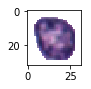

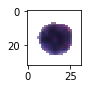

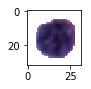

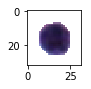

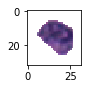

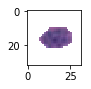

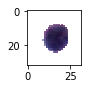

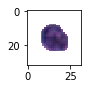

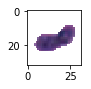

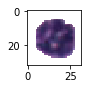

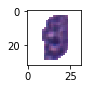

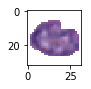

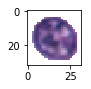

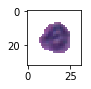

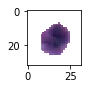

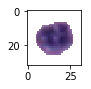

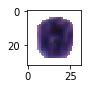

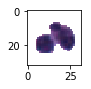

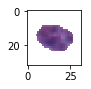

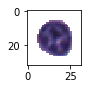

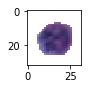

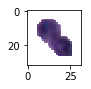

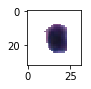

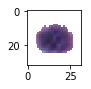

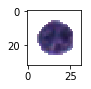

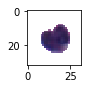

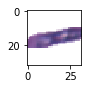

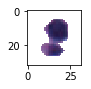

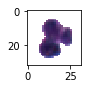

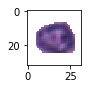

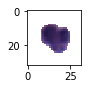

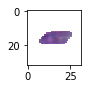

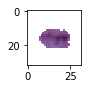

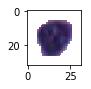

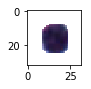

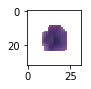

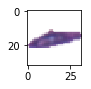

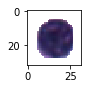

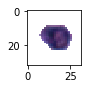

In [23]:
for img in listt:
    color_mean = img.mean(axis=2)
    for i in range(0, color_mean.shape[0]):
        for j in range(0, color_mean.shape[1]):
            if color_mean[i,j] == 0.0:
                img[i,j,:] = 255

    height, width = img.shape[0], img.shape[1]
    if max(height,width)>32:
        scale = 32/float(max(height,width))
        height, width = int(height*scale), int(width*scale)
        img = sp.misc.imresize(img, (height, width))

    npad = ((16-height/2,32-height-(16-height/2)),(16-width/2,32-width-(16-width/2)),(0,0))
    segmentate_image = np.pad(img, pad_width=npad,constant_values=255,mode='constant')
    plt.imshow(segmentate_image)
    plt.show()

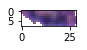

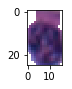

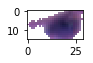

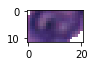

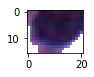

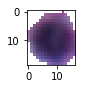

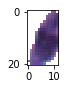

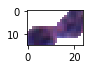

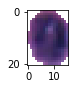

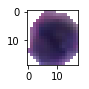

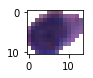

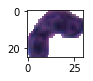

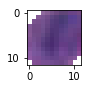

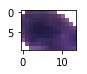

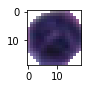

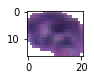

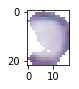

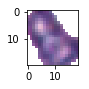

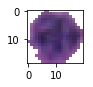

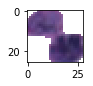

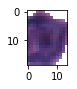

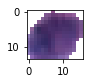

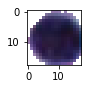

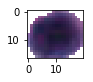

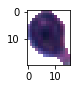

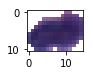

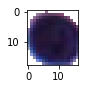

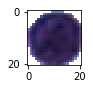

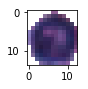

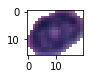

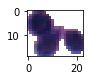

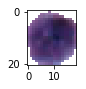

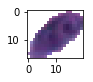

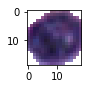

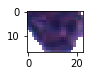

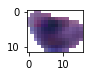

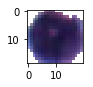

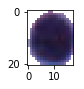

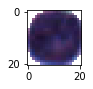

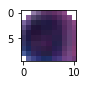

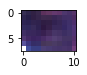

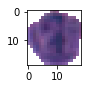

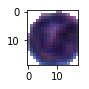

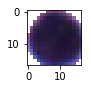

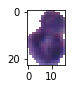

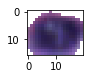

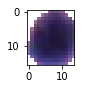

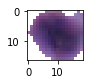

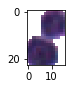

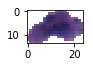

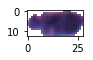

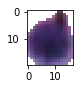

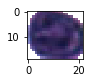

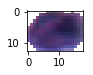

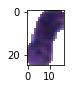

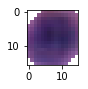

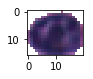

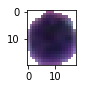

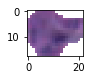

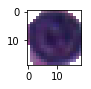

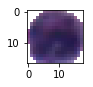

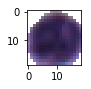

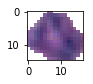

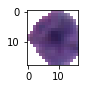

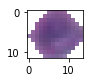

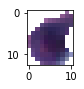

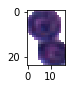

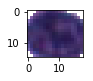

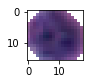

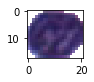

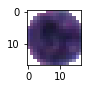

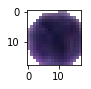

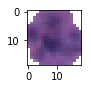

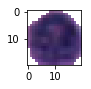

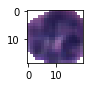

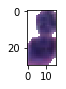

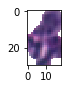

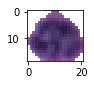

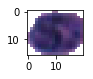

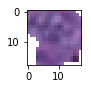

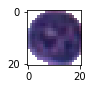

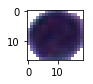

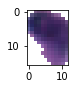

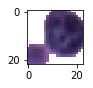

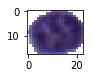

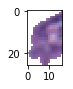

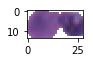

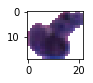

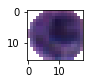

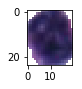

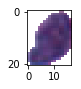

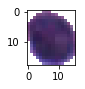

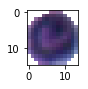

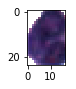

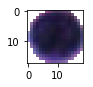

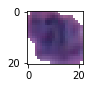

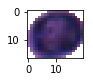

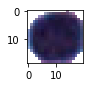

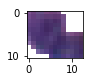

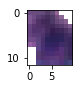

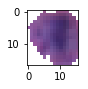

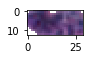

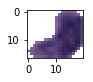

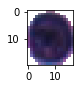

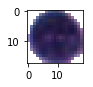

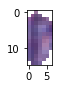

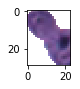

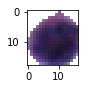

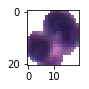

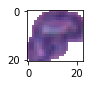

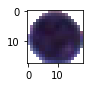

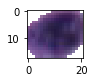

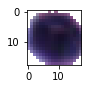

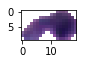

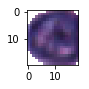

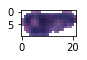

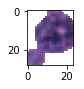

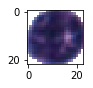

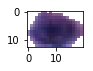

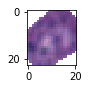

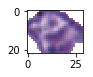

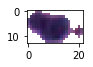

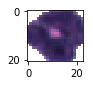

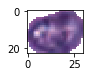

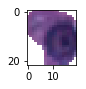

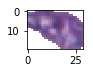

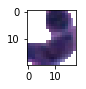

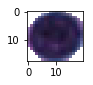

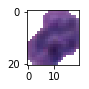

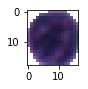

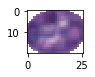

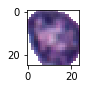

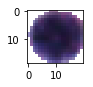

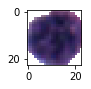

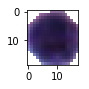

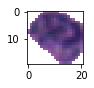

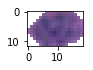

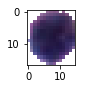

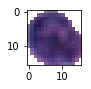

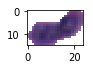

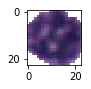

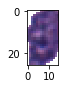

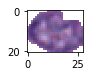

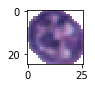

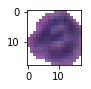

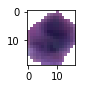

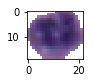

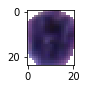

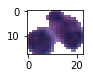

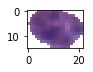

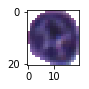

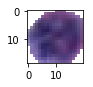

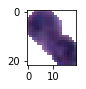

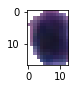

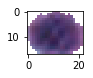

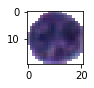

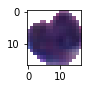

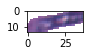

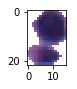

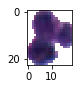

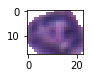

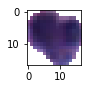

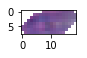

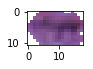

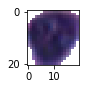

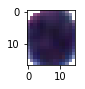

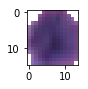

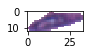

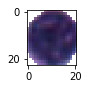

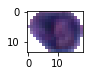

In [19]:
for img in listt:
    color_mean = img.mean(axis=2)
    for i in range(0, color_mean.shape[0]):
        for j in range(0, color_mean.shape[1]):
            if color_mean[i,j] == 0.0:
                img[i,j,:] = 255
                #print(img[i,j,:])
    plt.imshow(img)
    plt.show()

1
()


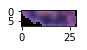

2
()


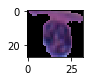

3
()


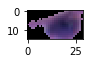

4
()


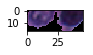

5
()


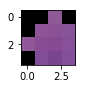

6
()


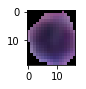

7
()


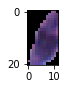

8
()


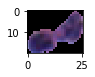

9
()


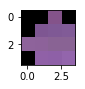

10
()


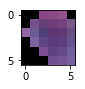

11
()


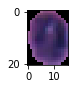

12
()


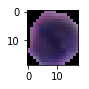

13
()


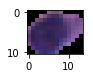

14
()


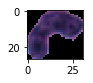

15
()


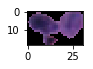

16
()


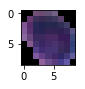

17
()


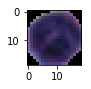

18
()


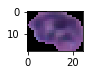

19
()


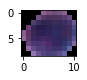

20
()


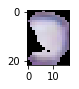

21
()


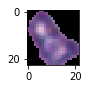

22
()


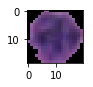

23
()


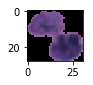

24
()


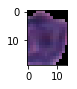

25
()


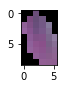

26
()


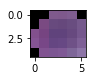

27
()


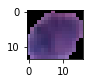

28
()


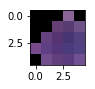

29
()


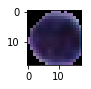

30
()


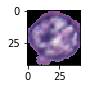

31
()


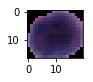

32
()


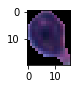

33
()


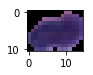

34
()


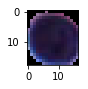

35
()


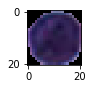

36
()


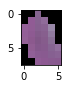

37
()


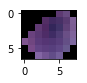

38
()


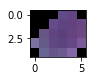

39
()


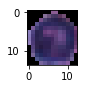

40
()


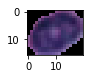

41
()


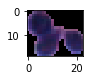

42
()


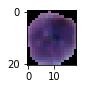

43
()


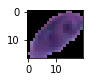

44
()


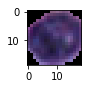

45
()


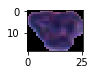

46
()


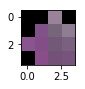

47
()


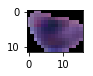

48
()


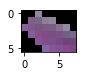

49
()


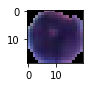

50
()


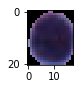

51
()


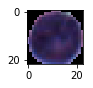

52
()


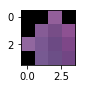

53
()


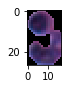

54
()


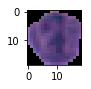

55
()


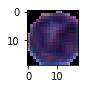

56
()


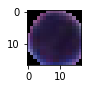

57
()


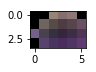

58
()


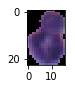

59
()


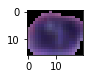

60
()


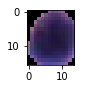

61
()


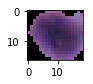

62
()


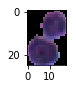

63
()


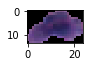

64
()


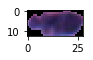

65
()


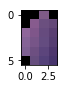

66
()


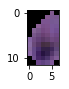

67
()


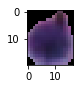

68
()


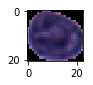

69
()


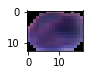

70
()


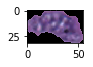

71
()


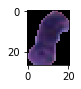

72
()


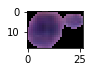

73
()


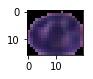

74
()


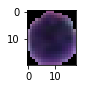

75
()


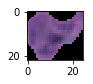

76
()


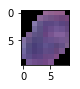

77
()


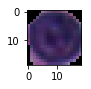

78
()


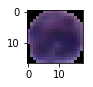

79
()


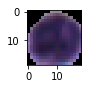

80
()


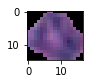

81
()


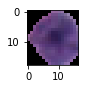

82
()


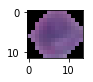

83
()


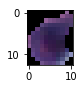

84
()


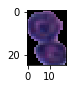

85
()


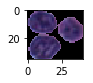

86
()


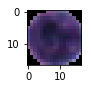

87
()


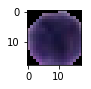

88
()


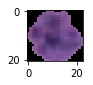

89
()


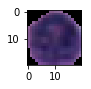

90
()


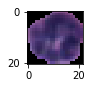

91
()


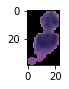

92
()


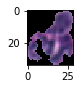

93
()


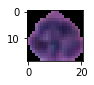

94
()


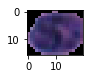

95
()


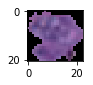

96
()


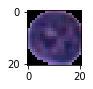

97
()


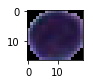

98
()


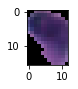

99
()


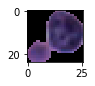

100
()


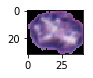

101
()


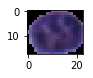

102
()


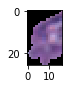

103
()


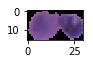

104
()


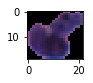

105
()


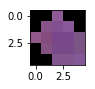

106
()


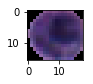

107
()


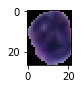

108
()


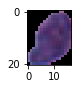

109
()


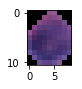

110
()


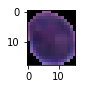

111
()


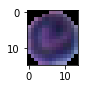

112
()


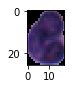

113
()


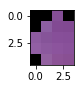

114
()


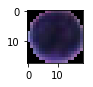

115
()


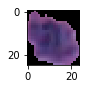

116
()


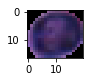

117
()


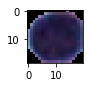

118
()


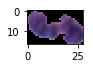

119
()


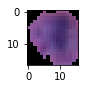

120
()


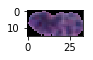

121
()


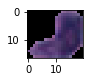

122
()


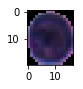

123
()


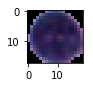

124
()


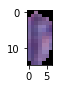

125
()


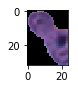

126
()


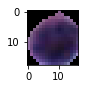

127
()


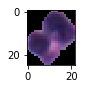

128
()


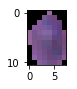

129
()


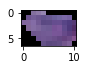

130
()


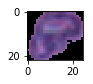

131
()


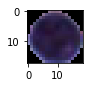

132
()


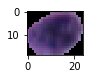

133
()


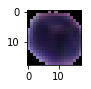

134
()


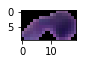

135
()


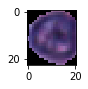

136
()


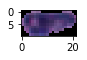

137
()


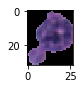

138
()


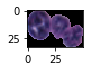

139
()


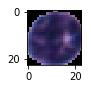

140
()


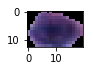

141
()


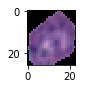

142
()


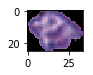

143
()


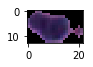

144
()


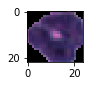

145
()


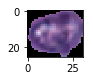

146
()


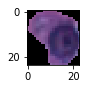

147
()


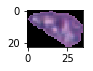

148
()


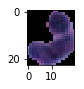

149
()


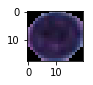

150
()


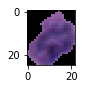

151
()


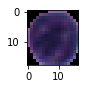

152
()


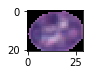

153
()


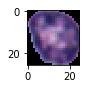

154
()


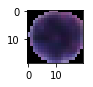

155
()


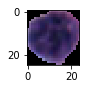

156
()


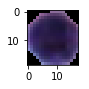

157
()


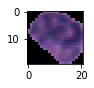

158
()


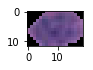

159
()


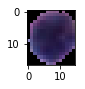

160
()


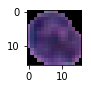

161
()


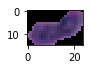

162
()


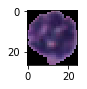

163
()


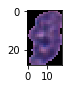

164
()


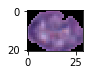

165
()


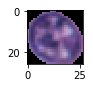

166
()


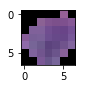

167
()


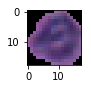

168
()


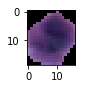

169
()


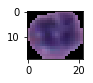

170
()


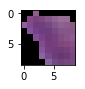

171
()


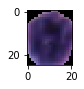

172
()


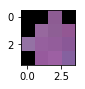

173
()


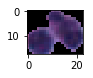

174
()


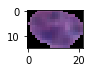

175
()


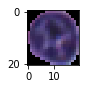

176
()


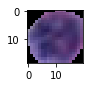

177
()


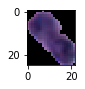

178
()


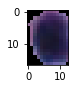

179
()


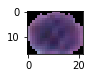

180
()


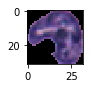

181
()


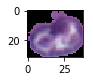

182
()


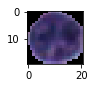

183
()


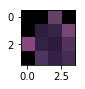

184
()


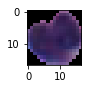

185
()


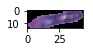

186
()


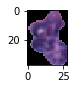

187
()


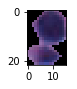

188
()


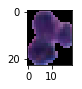

189
()


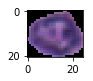

190
()


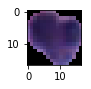

191
()


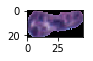

192
()


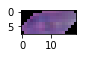

193
()


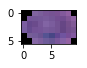

194
()


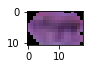

195
()


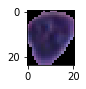

196
()


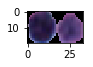

197
()


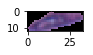

198
()


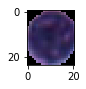

199
()


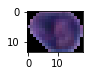

In [3]:
imInput2 = np.copy(imInput)
plt.rcParams['figure.figsize'] = 1, 1

for i in range(1,200):
    print i
    k =  (imNucleicompact2==i)
    location = np.where(k == 1)
    x_min, y_min = min(location[0]),min(location[1])
    x_max, y_max = max(location[0]),max(location[1])
    print()
    segmentate = k[x_min:x_max,y_min:y_max]
    segmentate = np.tile(np.expand_dims(segmentate,axis=2),(1,1,3))
    
    img = imInput2[x_min:x_max,y_min:y_max,:]
    img = img*segmentate
    plt.imshow(img)
    plt.show()